<a href="https://colab.research.google.com/github/aravind-thalla/XAI-Assignment/blob/main/Lab_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np, pandas as pd
from sklearn.linear_model import LinearRegression


X = np.array([1, 3, 2, 1, 3]).reshape(-1, 1)
y = np.array([80, 120, 95, 85, 130])


model = LinearRegression().fit(X, y)
baseline = y.mean()
preds = model.predict(X)
shap_vals = preds - baseline

df = pd.DataFrame({"Emails": X.ravel(), "Actual": y, "Pred": preds,
                   "Baseline": baseline, "SHAP": shap_vals,
                   "Note": np.where(y > preds, "Under", "Over")})

print(f"y = {model.intercept_:.2f} + {model.coef_[0]:.2f}*Emails")
print(df)


y = 59.50 + 21.25*Emails
   Emails  Actual    Pred  Baseline   SHAP   Note
0       1      80   80.75     102.0 -21.25   Over
1       3     120  123.25     102.0  21.25   Over
2       2      95  102.00     102.0   0.00   Over
3       1      85   80.75     102.0 -21.25  Under
4       3     130  123.25     102.0  21.25  Under


Problem 2

In [ ]:
import numpy as np, pandas as pd
from sklearn.linear_model import LinearRegression

# Data
X = np.array([[200, 10],
              [300, 15],
              [250, 5],
              [150, 10],
              [100, 0]], dtype=float)
y = np.array([1500, 2000, 1700, 1400, 1000], dtype=float)

model = LinearRegression().fit(X, y)
coef = model.coef_
intercept = model.intercept_


baseline = y.mean()


preds = model.predict(X)
total_shap = preds - baseline

raw = (coef * X)
raw_sum = raw.sum(axis=1)
mask_zero = raw_sum == 0


expanded_mask_zero = np.tile(~mask_zero[:, None], (1, raw.shape[1]))

weights = np.where(expanded_mask_zero, raw / raw_sum[:, None],
                   np.abs(raw) / np.abs(raw).sum(axis=1)[:, None])
feat_shap = total_shap[:, None] * weights


check = baseline + feat_shap.sum(axis=1)
df = pd.DataFrame({
    "Ad_Spend": X[:,0], "Discount": X[:,1], "Actual": y,
    "Predicted": preds.round(2), "Baseline": round(baseline,2),
    "SHAP_Ad": feat_shap[:,0].round(2), "SHAP_Disc": feat_shap[:,1].round(2),
    "Check": check.round(2), "Error": (y - preds).round(2)
})
print(f"Model: Revenue = {intercept:.3f} + {coef[0]:.3f}*Ad + {coef[1]:.3f}*Disc")
print("\nBaseline (mean revenue):", round(baseline,2))
print("\n", df.to_string(index=False))

print("\nInterpretations:")
for i, r in df.iterrows():
    ad_c = r.SHAP_Ad; d_c = r.SHAP_Disc
    influence = ("Ad spend ↑" if ad_c>0 else "Ad spend ↓") + f" ({ad_c})"
    influence += " ; " + (("Discount ↑" if d_c>0 else "Discount ↓") + f" ({d_c})")
    note = "Under-pred" if r.Error>0 else "Over-pred"
    print(f" Row {i+1}: {influence} → Pred={r.Predicted}, Actual={r.Actual} ({note}, err={r.Error})")

Model: Revenue = 628.148 + 3.896*Ad + 14.074*Disc

Baseline (mean revenue): 1520.0

  Ad_Spend  Discount  Actual  Predicted  Baseline  SHAP_Ad  SHAP_Disc   Check  Error
    200.0      10.0  1500.0    1548.15    1520.0    23.84       4.31 1548.15 -48.15
    300.0      15.0  2000.0    2008.15    1520.0   413.47      74.68 2008.15  -8.15
    250.0       5.0  1700.0    1672.59    1520.0   142.31      10.28 1672.59  27.41
    150.0      10.0  1400.0    1353.33    1520.0  -134.32     -32.35 1353.33  46.67
    100.0       0.0  1000.0    1017.78    1520.0  -502.22      -0.00 1017.78 -17.78

Interpretations:
 Row 1: Ad spend ↑ (23.84) ; Discount ↑ (4.31) → Pred=1548.15, Actual=1500.0 (Over-pred, err=-48.15)
 Row 2: Ad spend ↑ (413.47) ; Discount ↑ (74.68) → Pred=2008.15, Actual=2000.0 (Over-pred, err=-8.15)
 Row 3: Ad spend ↑ (142.31) ; Discount ↑ (10.28) → Pred=1672.59, Actual=1700.0 (Under-pred, err=27.41)
 Row 4: Ad spend ↓ (-134.32) ; Discount ↓ (-32.35) → Pred=1353.33, Actual=1400.0 (Under

Problem 3

In [ ]:
import pandas as pd, numpy as np
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = load_diabetes()
X, y = pd.DataFrame(data.data, columns=data.feature_names), pd.Series(data.target, name="progression")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = LinearRegression().fit(X_train, y_train)
coef, intercept = model.coef_, model.intercept_

baseline = y_train.mean()

mean_train = X_train.mean()
shap_vals = (X_test - mean_train) * coef

preds = model.predict(X_test)
check = baseline + shap_vals.sum(axis=1)

results = X_test.copy()
results["Actual"] = y_test.values
results["Predicted"] = preds.round(2)
results["Baseline"] = round(baseline, 2)
for f in X.columns:
    results[f"SHAP_{f}"] = shap_vals[f].round(2)
results["Check"] = check.round(2)
results["Error"] = (y_test - preds).round(2)

pd.set_option("display.max_columns", None)
print(f"Model: progression = {intercept:.3f} + Σ(coef_i * feature_i)")
print("Baseline:", round(baseline, 2))
print(results.head())


for i, row in results.head(3).iterrows():
    contribs = ", ".join([f"{f}({row[f'SHAP_{f}']:+})" for f in X.columns])
    status = "Overpredicted" if row.Error < 0 else "Underpredicted"
    print(f"\nPatient {i}: {status} by {abs(row.Error)} → {contribs}")


Model: progression = 151.665 + Σ(coef_i * feature_i)
Baseline: 154.34
          age       sex       bmi        bp        s1        s2        s3  \
287  0.045341 -0.044642 -0.006206 -0.015999  0.125019  0.125198  0.019187   
211  0.092564 -0.044642  0.036907  0.021872 -0.024960 -0.016658  0.000779   
72   0.063504  0.050680 -0.004050 -0.012556  0.103003  0.048790  0.056003   
321  0.096197 -0.044642  0.051996  0.079265  0.054845  0.036577 -0.076536   
73   0.012648  0.050680 -0.020218 -0.002228  0.038334  0.053174 -0.006584   

           s4        s5        s6  Actual  Predicted  Baseline  SHAP_age  \
287  0.034309  0.032432 -0.005220   219.0     137.95    154.34      2.12   
211 -0.039493 -0.022517 -0.021788    70.0     182.53    154.34      4.37   
72  -0.002592  0.084492 -0.017646   202.0     129.85    154.34      2.98   
321  0.141322  0.098648  0.061054   230.0     292.56    154.34      4.54   
73   0.034309 -0.005142 -0.009362   111.0     124.87    154.34      0.56   

     SHAP_

Problem 4

Baseline (mean final score): 70.5

Results:
    study_time  parent_edu  absences  health  final_score  predicted  \
0           1           2         8       2           58  64.645726   
1           4           4         1       1           75  60.629313   
2           2           2         6       2           64  64.066344   
3           1           3         7       5           89  82.310045   
4           4           1         7       4           91  81.776155   
5           4           4         8       1           69  74.989015   
6           4           3         1       4           59  74.906429   
7           4           1         5       1           59  60.676974   

       error over/under  
0  -6.645726       Over  
1  14.370687      Under  
2  -0.066344       Over  
3   6.689955      Under  
4   9.223845      Under  
5  -5.989015       Over  
6 -15.906429       Over  
7  -1.676974       Over  

All predictions match baseline+SHAP? -> True


/tmp/ipython-input-809217766.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


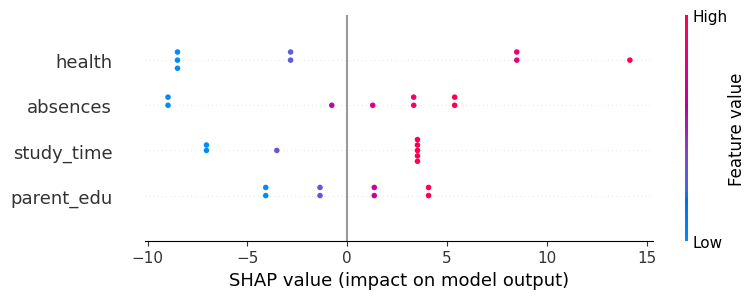

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import shap

np.random.seed(0)
data = pd.DataFrame({
    'study_time': np.random.randint(1, 5, 8),
    'parent_edu': np.random.randint(1, 5, 8),
    'absences': np.random.randint(0, 10, 8),
    'health': np.random.randint(1, 6, 8),
    'final_score': np.random.randint(40, 100, 8)
})

X = data.drop('final_score', axis=1)
y = data['final_score']

model = LinearRegression().fit(X, y)

baseline = y.mean()

explainer = shap.Explainer(model, X)
shap_values = explainer(X)

preds = model.predict(X)

check = np.isclose(preds, baseline + shap_values.values.sum(axis=1))

result = data.copy()
result['predicted'] = preds
result['error'] = y - preds
result['over/under'] = np.where(result['error'] > 0, 'Under', 'Over')

print("Baseline (mean final score):", baseline)
print("\nResults:\n", result)
print("\nAll predictions match baseline+SHAP? ->", check.all())

shap.summary_plot(shap_values, X)
